In [1]:
cd ..

/Users/wmorning/research/EvilLens


In [2]:
import evillens as evil
import numpy as np
import matplotlib.pyplot as plt
import struct
%matplotlib inline
from astropy import units,constants

evillens/analyticSIELens.py:77: RuntimeWarning: divide by zero encountered in divide
  self.kappa = np.sqrt(self.q)/(2.0*np.sqrt(r**2+bc**2))
/Users/wmorning/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


('Mass Enclosed in ', 3.32, ' kpc is ', <Quantity 124822887716.86717 solMass>, ' solar masses \n')
('Mass Enclosed in ', 10.0, ' kpc is ', <Quantity 375972553364.05774 solMass>, ' solar masses \n')
1.24821928267e+11 solMass


/Users/wmorning/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


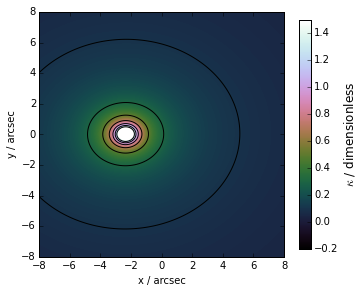

In [3]:
lens = evil.AnalyticSIELens(0.140,3.369)
lens.setup_grid(NX=3200,NY=3200,pixscale=0.005)
#lens.image_x +=-2.35
#lens.image_y += 0.02
sigma = ((1.36*units.arcsec.to(units.rad))**2*constants.c**2/constants.G/4.0*(lens.Dd*lens.Ds/lens.Dds)).to(units.solMass)
r_e = 1.36*units.arcsec.to(units.rad)*lens.Dd
lens.build_kappa_map(sigma=226.905,q=0.83,centroid = [-2.35,0.02],rotation=91.0*np.pi/180.0)
lens.print_mass_inside(3.32)
lens.print_mass_inside(10.0)
print(sigma)
lens.deflect()
lens.plot('kappa')

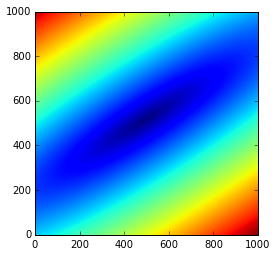

In [6]:
lens.source = evil.Source(3.369)
lens.source.setup_grid(NX=1000,NY=1000,pixscale=0.002)
lens.source.beta_x +=-2.35
lens.source.beta_y +=0.02
lens.source.build_from_clumps(size = 1.8790535,axis_ratio=0.22,Nclumps=1,center=[-0.02-2.35,0.02+0.03],n=0.96)
theta = (90+122.0)/180.0*np.pi
center = lens.source.center
q=0.22
x = np.cos(theta)*(lens.source.beta_x-center[0])+np.sin(theta)*(lens.source.beta_y-center[1])
y = -np.sin(theta)*(lens.source.beta_x-center[0])+(np.cos(theta)*(lens.source.beta_y-center[1]))
r = np.sqrt(q*x**2+y**2/q)
lens.source.intensity = np.exp(-lens.source.b_n*((r/(lens.source.size))**(1/lens.source.n)-1))
plt.imshow(r,origin='lower')

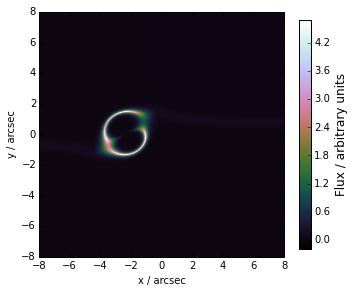

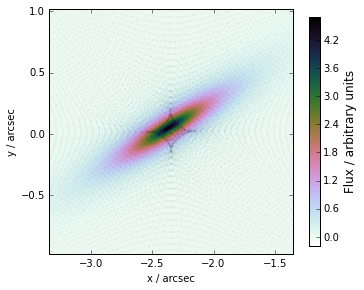

In [8]:
lens.raytrace()
lens.plot('lensed image')
lens.plot('non-lensed image')
lens.write_image_to('../data/HansGruber/HansGruber2.fits')

In [11]:
saboteur = evil.Saboteur(50,0.00214,160)
saboteur.read_data_from('/Users/wmorning/research/data/HansGruber/HansGruber3/HansGruber3.alma.cycle2.7.ms','alma.cycle2.7.cfg')

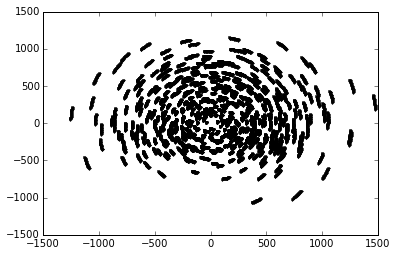

In [12]:
plt.plot(saboteur.u,saboteur.v,'k.')

In [25]:
#make dirty image
U = saboteur.u/saboteur.wavelength
V = saboteur.v/saboteur.wavelength

image_x,image_y = np.meshgrid(np.arange(-7.5,2.5,0.1),np.arange(-4.5,4.5,0.1))
image_x /= (3600*180/np.pi)
image_y /= (3600*180/np.pi)

image_dirty1 = np.zeros(image_x.shape)
#image_dirty2 = np.zeros(image_x.shape)
for i in range(image_x.shape[0]):
    for j in range(image_x.shape[1]):
        image_dirty1[i,j]  = 2.0*np.sum(saboteur.Visibilities*np.exp(1j*2*np.pi*(U*image_x[i,j]+V*image_y[i,j]))).real
#        image_dirty2[i,j] = 2.0*np.sum(Vis_model*np.exp(1j*2*np.pi*(U*image_x[i,j]+V*image_y[i,j]))).real

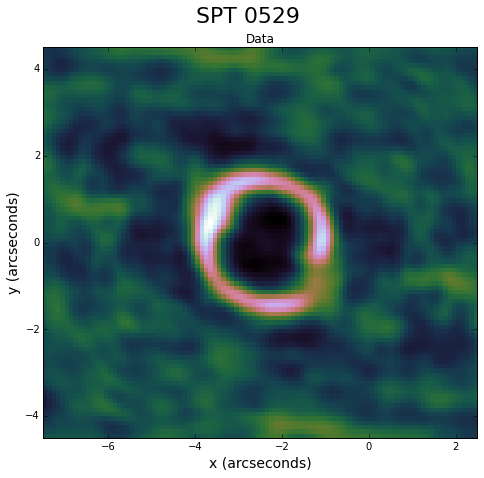

In [27]:
fig = plt.figure(figsize=[15,7])
plt.suptitle('SPT 0529',fontsize=22)
#gs = gridspec.GridSpec(1,3)
#gs.update(left=0.1, right=0.9, wspace=0.03)
#plt.subplot(gs[0,0])
plt.imshow(image_dirty1.real,origin='lower',extent=(-7.5,2.5,-4.5,4.5),cmap='cubehelix',interpolation='nearest')
plt.title('Data')
plt.ylabel('y (arcseconds)',fontsize=14)
plt.xlabel('x (arcseconds)',fontsize=14)

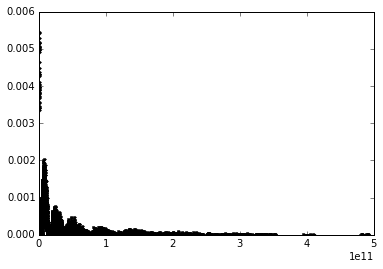

In [23]:
plt.plot(U**2+V**2,saboteur.Visibilities.real**2+saboteur.Visibilities.imag**2,'k.')

In [20]:
saboteur.add_noise(rms=0.00174418308576)

In [17]:
with open('/Users/wmorning/research/data/CITA/SPT0529/sigma_squared_inv.bin', mode='rb') as file: # b is important -> binary
    fileContent = file.read()
    temp =struct.unpack("d"*(len(fileContent)//8),fileContent)
file.close()

In [36]:
saboteur.u/=saboteur.wavelength
saboteur.v/=saboteur.wavelength

vis_data = np.empty(2*len(saboteur.Visibilities),float)
for i in range(len(saboteur.Visibilities)):
    vis_data[2*i] = saboteur.Visibilities[i].real
    vis_data[2*i+1] = saboteur.Visibilities[i].imag
f = open('../data/HansGruber/vis_chan_0.bin','wb')
data = struct.pack('d'*len(vis_data),*vis_data)
f.write(data)
f.close()

g = open('../data/HansGruber/u.bin','wb')
data = struct.pack('d'*len(saboteur.u),*saboteur.u)
g.write(data)
g.close()

h = open('../data/HansGruber/v.bin','wb')
data = struct.pack('d'*len(saboteur.v),*saboteur.v)
h.write(data)
h.close()

chan = np.zeros(len(saboteur.u),float)
i = open('../data/HansGruber/chan.bin','wb')
data = struct.pack('d'*len(chan),*chan)
i.write(data)
i.close()

sigma_squared_inv = 1.0/(0.00174418308576**2)*np.ones(2*len(saboteur.Visibilities),float)
print(len(sigma_squared_inv))
j = open('../data/HansGruber/sigma_squared_inv.bin', 'wb')
data = struct.pack('d'*len(sigma_squared_inv), *sigma_squared_inv)
j.write(data)
j.close()

16830


In [56]:
lens.print_mass_inside(10.0)
np.log10(375972553364.05774*np.sqrt(lens.q))/10.0

('Mass Enclosed in ', 10.0, ' kpc is ', <Quantity 375972553364.05774 solMass>, ' solar masses \n')


1.1534695188036941

In [117]:
ellipticity = 1-0.83
angle = np.pi/2.0+lens.rotation


In [118]:
e_x = ellipticity*np.cos(angle)
e_y = ellipticity*np.sin(angle)
print(e_x,e_y)


e_x = 0.051573
e_y = 0.21941

print(np.sqrt(e_x**2+e_y**2))
print(np.arctan2(e_y,e_x)*180.0/np.pi)

(-0.16997410817658656, -0.0029669090943381434)
0.225389712341
76.7725658258


In [111]:
print(e_x*10,e_y*10)

(-0.029669090943381909, 1.6997410817658656)


In [35]:
print(np.max(saboteur.u))

1470.4484581


In [119]:
src=np.loadtxt('/Users/wmorning/research/data/HansGruber/SPT0529_HansGruber_evalmod_ModelSrc.txt').reshape([60,60]).T
img=np.loadtxt('/Users/wmorning/research/data/HansGruber/SPT0529_HansGruber_evalmod_ModelImg.txt').reshape([80,80]).T

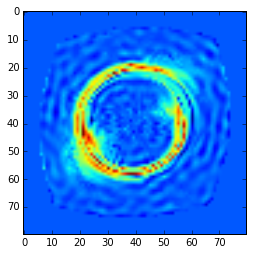

In [120]:
plt.imshow(img)

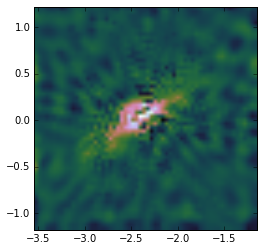

In [121]:
plt.imshow(src,cmap='cubehelix',extent=(-2.35-1.2,-2.35+1.2,0.02-1.2,0.02+1.2))
plt.xlim(-2.35-1.2,-2.35+1.2)
plt.ylim(0.02-1.2,0.02+1.2)
x = np.loadtxt('/Users/wmorning/research/data/HansGruber/NAME_X.txt')
y = np.loadtxt('/Users/wmorning/research/data/HansGruber/NAME_Y.txt')

x*= 3600*180/np.pi
y *= 3600*180/np.pi

#for i in range(40):
#    plt.plot(x[2*i,:],y[2*i,:],'r-',linewidth=0.3)
#    plt.plot(x[:,2*i],y[:,2*i],'r-',linewidth=0.3)
    


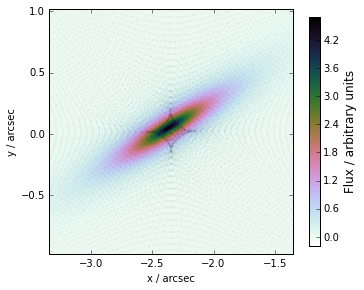

In [90]:
lens.plot('non-lensed image')